# Calculations using CO2 EOS
- DiadFit includes the Span and Wanger (1996) and Sterner and Pitzer (1994) EOS.
- This allows lots of useful calculations to be performed which rely on these equation of states

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import DiadFit as pf
pf.__version__

'0.0.50'

## There are 3 main classes of calculations you can do using an EOS
1) calculate CO$_2$ given a homogenization temp. This requires knowledge of the position of the L-V phase boundary. This is only currently supported in Span and Wanger (1996), using the function 'calculate_CO2_density_homog_T'

2) Calculate CO$_2$ density for a given P-T. using the function 'calculate_rho_gcm3_for_P_T' with EOS='SP94' or 'SW96'

3) Calculate Pressure for a given T and CO$_2$ density, using the function 'calculate_P_for_rho_T', can use EOS='SP94' or 'SW96'

## Example 1: Calculating densities in 2 phase bubbles at room temp
- We have parameterized the L-V curve using the Span and Wanger (1996) EOS. 
- This means you can enter a temperature, and find out what the density of the CO$_2$ gas and liquid would be for an inclusion following the grey line on the below phase diagram
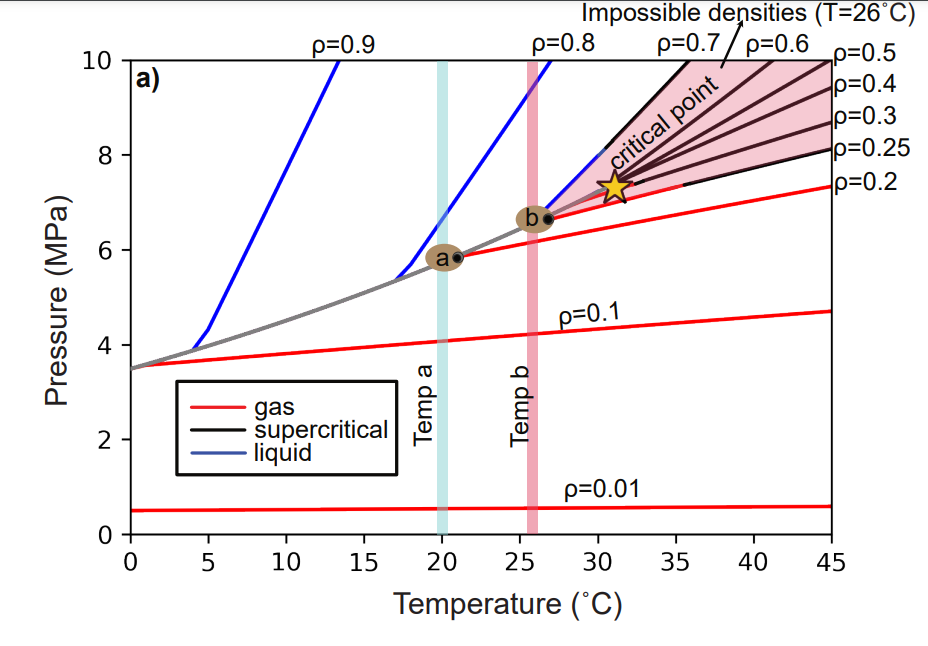

 - This can be very useful, because if you are conducting Raman analyses at room temperature for bubbles with densities higher than the critical density, you will only analyse the interior gas (with complex interactions with the liquid phase, see DeVitre et al. 2023).

In [2]:
# Lets consider 'room Temps' between 18 and 23C using Span and Wagner 1996
Temps=np.linspace(17, 25)
df_roomT_SW96=pf.calculate_CO2_density_homog_T(T_h_C=Temps, EOS='SW96')
df_roomT_SW96.head()

,Bulk_gcm3,Liq_gcm3,Gas_gcm3,T_h_C,homog_to
0,NaN,0.803262,0.172932,17.000000,None
1,NaN,0.801736,0.173990,17.163265,None
2,NaN,0.800200,0.175058,17.326531,None
3,NaN,0.798654,0.176137,17.489796,None
4,NaN,0.797097,0.177226,17.653061,None


Text(0, 0.5, 'Gas density (g/cm3)')

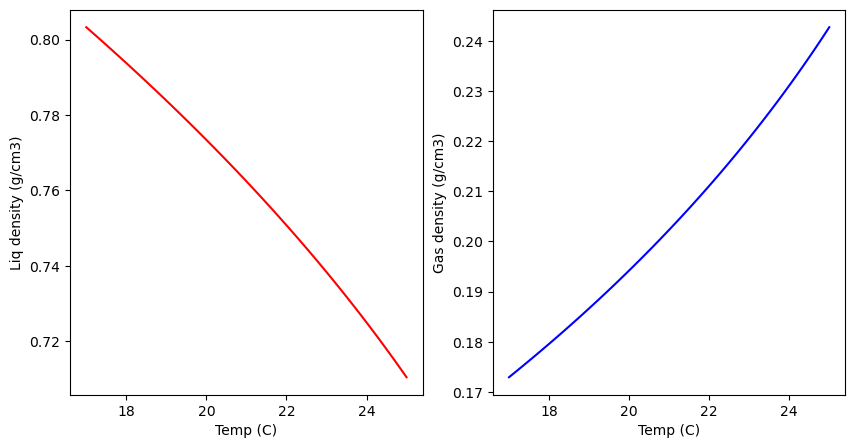

In [3]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
ax1.plot(Temps, df_roomT_SW96['Liq_gcm3'], '-r', label='SW96')
ax2.plot(Temps, df_roomT_SW96['Gas_gcm3'], '-b', label='SW96')

ax1.set_xlabel('Temp (C)')
ax1.set_ylabel('Liq density (g/cm3)')
ax2.set_xlabel('Temp (C)')
ax2.set_ylabel('Gas density (g/cm3)')

## Example 2 - Calculating homogenization temperatures from microthermometry
- Microthermometry works by cooling CO$_2$ rich fluid inclusions down, and then heating up until the liquid and gas homogenizes to a single phase. This gives you the density of CO2. You can then calculate the pressure by extrapolating 
- Again, we use the Span and Wagner (1996) EOS. We note that some existing spreadsheets use the L-V curve from Span and Wanger, but extrapolate using Sterner and Pitzer (1994). We do not wish to mix and match EOS, so use SW96 for the L-V curve and extrapolating along the isochore

### Lets perform calcs for one FI, e.g. while we are on the microscope and are very excited to get the density!
- Say we see the homogenization at -18C, and it homogenizes to a liquid, we know the density is 1.022 g/cm3

In [4]:
Density1=pf.calculate_CO2_density_homog_T(T_h_C=-18, Sample_ID='FI2',
                            homog_to='L', EOS='SW96')
Density1

,Bulk_gcm3,Liq_gcm3,Gas_gcm3,T_h_C,homog_to
0,1.022329,1.022329,0.055156,-18,L


### Now lets load in an entire days data from an Excel spreadsheet

In [5]:
homog_t=pd.read_excel('Batch_processing_TC.xlsx')
homog_t.head()

,T_c_Homog,Sample,homog_to
0,30,FI1,L
1,25,FI2,L
2,20,FI3,L
3,15,FI4,L
4,10,FI5,L


In [6]:
Whole_day_dens=pf.calculate_CO2_density_homog_T(T_h_C=homog_t['T_c_Homog'],
            Sample_ID=homog_t['Sample'], homog_to=homog_t['homog_to'], EOS='SW96')
Whole_day_dens.head()

0     L
1     L
2     L
3     L
4     L
5     L
6     L
7     L
8     L
9     L
10    L
11    L
12    L
13    V
Name: homog_to, dtype: object


,Bulk_gcm3,Liq_gcm3,Gas_gcm3,T_h_C,homog_to
0,0.593263,0.593263,0.345003,30,L
1,0.710471,0.710471,0.242710,25,L
2,0.773392,0.773392,0.194204,20,L
3,0.821187,0.821187,0.160735,15,L
4,0.861096,0.861096,0.135157,10,L


## Example 3 - Calculating Pressures from densities and entrapment temps
- The fundamental tenet of fluid inclusion barometry is that your inclusion has a fixed mass and volume. This means if you can get its density today in the lab using microthermometry or Raman Spectroscopy, and you can choose an entrapment temperature, you can calculate a pressure
- We can extrapolate along an isopleth using Span and Wanger (1996), or Sterner and Pitzer (1994)
- This uses the function 'calculate_P_for_rho_T'

In [7]:
# Chose an array of temperatures
T_C=np.linspace(0, 2000, 100)
T_K=T_C+273.15
# Choose an array of densities (g/cm3)
rho_lin=np.linspace(1.1, 0.1, 11)
# Now write a loop to fill out a pressure array
Pressure_SP94=np.empty([len(rho_lin), len(T_K)], float)
Pressure_SW96=np.empty([len(rho_lin), len(T_K)], float)
for i in range(0, len(rho_lin)):
    P_SW96=pf.calculate_P_for_rho_T(density_gcm3=rho_lin[i], T_K=T_K, EOS='SW96').P_kbar
    Pressure_SW96[i, :]=P_SW96
    P_SP94=pf.calculate_P_for_rho_T(density_gcm3=rho_lin[i], T_K=T_K, EOS='SP94').P_kbar
    Pressure_SP94[i, :]=P_SP94
    

### plot for a single EOS

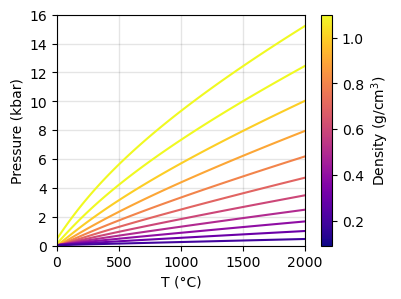

In [8]:
fig, (ax1) = plt.subplots(1, 1, figsize=(4,3), sharex=True, sharey=True)
import matplotlib.colors as colors
#ax1.plot(T_C, P_kbar, '-r')
import matplotlib.cm as cm
for i in range(0, len(rho_lin)):
    color=cm.plasma(rho_lin[i])
    ax1.plot(T_C, Pressure_SW96[i, :], '-',  
    color=color,label=str(np.round(rho_lin[i], 1)) + ' g/cm$^3$')
 

norm = colors.Normalize(vmin=rho_lin[0], vmax=rho_lin[-1])
sm = cm.ScalarMappable(cmap=cm.plasma, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm)
cbar.set_label('Density (g/cm$^3$)')



ax1.set_ylabel('Pressure (kbar)')
#legend = ax1.legend(loc='upper left', ncol=2, frameon=True, fontsize=7)
ax1.set_xlim([0, 2000])
ax1.set_ylim([0, 16])

ax1.set_xlabel('T (°C)')
ax1.grid(color = 'k', linestyle = '-', linewidth = 1, alpha = 0.1)

fig.savefig('EOS.png', dpi=200, bbox_inches='tight')

### Plot comparing different EOS

Text(0.5, 1.0, 'Comparing ST1994 and SP1996')

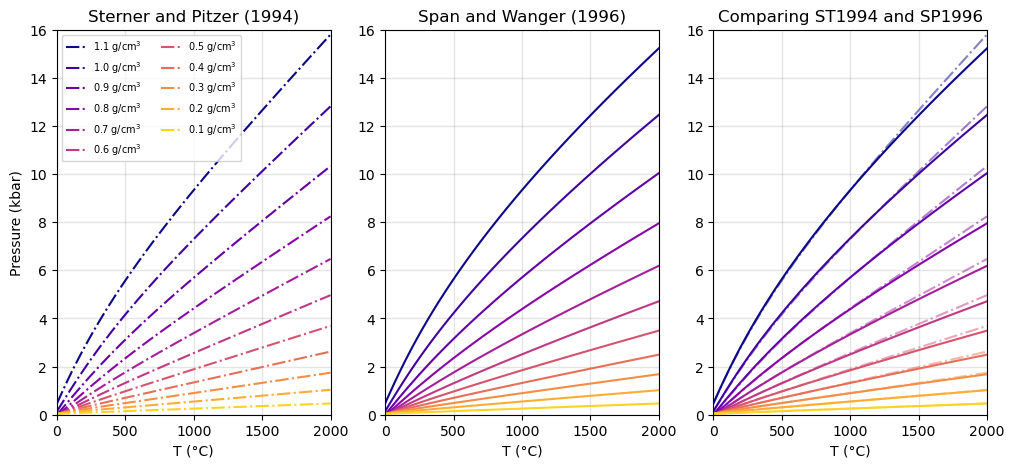

In [9]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12,5), sharex=True, sharey=True)
#ax1.plot(T_C, P_kbar, '-r')
import matplotlib.cm as cm
for i in range(0, len(rho_lin)):
    color=cm.plasma(i/len(rho_lin))
    ax1.plot(T_C, Pressure_SP94[i, :], '-.',  
    color=color,label=str(np.round(rho_lin[i], 1)) + ' g/cm$^3$')
    ax2.plot(T_C, Pressure_SW96[i, :], '-',  
    color=color,label=str(np.round(rho_lin[i], 1)) + ' g/cm$^3$')
    
    ax3.plot(T_C, Pressure_SW96[i, :], '-',  
    color=color,label=str(np.round(rho_lin[i], 1)) + ' g/cm$^3$')
    ax3.plot(T_C, Pressure_SP94[i, :], '-.',  
    color=color, label=str(np.round(rho_lin[i], 1)) + ' g/cm$^3$', alpha=0.5)
    

ax1.set_ylabel('Pressure (kbar)')
legend = ax1.legend(loc='upper left', ncol=2, frameon=True, fontsize=7)
ax1.set_xlim([0, 2000])
ax1.set_ylim([0, 16])
ax2.set_xlabel('T (°C)')
ax3.set_xlabel('T (°C)')
ax1.set_xlabel('T (°C)')
ax1.grid(color = 'k', linestyle = '-', linewidth = 1, alpha = 0.1)
ax2.grid(color = 'k', linestyle = '-', linewidth = 1, alpha = 0.1)
ax3.grid(color = 'k', linestyle = '-', linewidth = 1, alpha = 0.1)

ax2.yaxis.set_tick_params(which='both', labelbottom=True)
ax3.yaxis.set_tick_params(which='both', labelbottom=True)
ax1.set_title('Sterner and Pitzer (1994)')
ax2.set_title('Span and Wanger (1996)')
ax3.set_title('Comparing ST1994 and SP1996')

## Example 4 - Calculating density for given Pressure and temperature

In [10]:
P_kbar_linspace=np.linspace(0.01, 10, 50)
SW96_Parray_1400=pf.calculate_rho_gcm3_for_P_T(P_kbar=P_kbar_linspace, 
T_K=1400, EOS='SW96')
SP94_Parray_1400=pf.calculate_rho_gcm3_for_P_T(P_kbar=P_kbar_linspace, 
T_K=1400, EOS='SP94')

SW96_Parray_1200=pf.calculate_rho_gcm3_for_P_T(P_kbar=P_kbar_linspace, 
T_K=1200, EOS='SW96')
SP94_Parray_1200=pf.calculate_rho_gcm3_for_P_T(P_kbar=P_kbar_linspace, 
T_K=1200, EOS='SP94')

Text(0, 0.5, 'Density SW96-SP94 (g/cm3)')

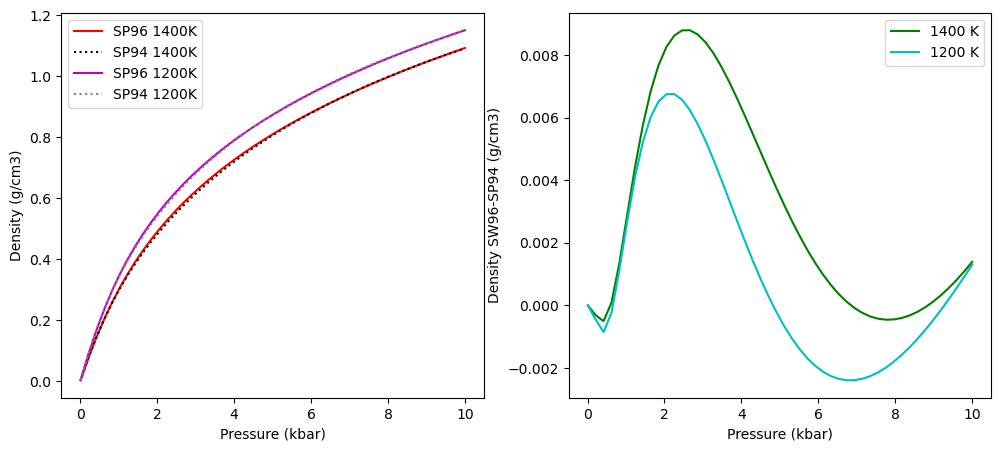

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5), sharex=True)

ax1.plot(P_kbar_linspace, SW96_Parray_1400, '-r', label='SP96 1400K')
ax1.plot(P_kbar_linspace, SP94_Parray_1400, ':k', label='SP94 1400K')


ax1.plot(P_kbar_linspace, SW96_Parray_1200, '-m', label='SP96 1200K')
ax1.plot(P_kbar_linspace, SP94_Parray_1200, ':', color='grey', label='SP94 1200K')
ax1.legend()

ax2.plot(P_kbar_linspace, SW96_Parray_1400-SP94_Parray_1400, '-g', label='1400 K')
ax2.plot(P_kbar_linspace, SW96_Parray_1200-SP94_Parray_1200, '-c', label='1200 K')
ax2.legend()


ax1.set_xlabel('Pressure (kbar)')
ax1.set_ylabel('Density (g/cm3)')

ax2.set_xlabel('Pressure (kbar)')
ax2.set_ylabel('Density SW96-SP94 (g/cm3)')

## Example 5 - Error propagation in microthermometry
- Lets say we measure a homogenization temp of -30 C, but there is a 0.3 C error on our stage temp, or we werent exactly sure when the bubble disapeared
- N dup says how many monte carlo simulations we are going to do. Lets say 1000. 

In [15]:
# First calculate density
Av_outputs_SW96, All_outputs_SW96=pf.propagate_microthermometry_uncertainty(T_h_C=-30, 
Sample_ID='test', error_T_h_C=0.3, N_dup=100,
EOS='SW96', homog_to='L',
error_dist_T_h_C='normal', error_type_T_h_C='Abs', len_loop=1)


Text(0.5, 0, 'gas (g/cm3)')

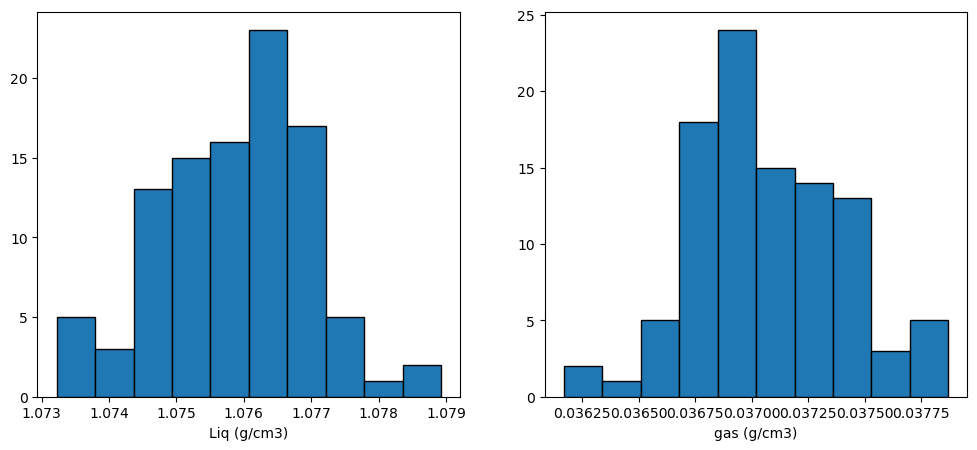

In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))
ax1.hist(All_outputs_SW96['Liq_gcm3'], ec='k');
ax2.hist(All_outputs_SW96['Gas_gcm3'], ec='k');
ax1.set_xlabel('Liq (g/cm3)')
ax2.set_xlabel('gas (g/cm3)')